---
title: "Ensemble Methods"
author: Daniel Redel
date: today
format:
  html:
    toc: true
    code-fold: false
    html-math-method: katex
jupyter: python3
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

An **ensemble method** is an approach that combines many simple “building ensemble block” models in order to obtain a single and potentially very powerful model.

We will now discuss **bagging**, **random forests** and **boosting**. These are ensemble methods for which the simple building block is a regression or a classification tree.

# Bagging

The decision trees discussed _suffer from **high variance**_. On the other hand, **averaging trees** with relatively high variance will typically result in a low variance procedure, with the same or even lower bias (because we average).

> **Bootstrap Aggregation**, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method; we introduce it here because it is particularly useful and frequently used in the context of decision trees.


## Model Training


Bagging classifier and regressor are implemented by `BaggingClassifier` and `BaggingRegressor` classes from `sklearn.ensemble`
 module,respectively. Using base_estimator parameter, both `BaggingClassifier` and `BaggingRegressor` can take as input a user-specified base model along with its hyperparameters. Another important hyperparameter in these constructors is `n_estimators` (by default it is 10). 

Recall that `RandomForest` bagging is simply a special case of a random forest with $m = p$. Therefore, the `RandomForestClassifier()` function can also be used to perform both bagging and random forests.

### Bagging Classifier

In [20]:
#| label: tbl-raw-dataset1
#| tbl-cap: Breast Cancer Dataset
#| code-fold: true
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

# Add target
df['target'] = cancer.target

df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


The base estimator to fit on random subsets of the dataset. If `None`, then the base estimator is a `DecisionTreeClassifier`.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier as Bagging
from sklearn.tree import DecisionTreeClassifier

# Target vs Inputs
X = df.drop(columns=["target"]) # Covariates-Only
y = df["target"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create the base classifier
base_classifier = DecisionTreeClassifier() # this is the default if we skip this step
 
# Number of base models (iterations)
n_estimators = 10 # default

# Initialize Bagging Classifier
bagging = Bagging(base_estimator=base_classifier, n_estimators=n_estimators, random_state=0)

# Train Model
bagging.fit(X_train, y_train)

# Predict
y_test_pred = bagging.predict(X_test)

In [4]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('Accuracy Train' , bagging.score(X_train, y_train).round(2) ) 
print('Accuracy Test' , bagging.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

Accuracy Train 1.0
Accuracy Test 0.94
Test MSE: 0.06


But maybe we can do better by using pruned trees:

#### Adjust `base_estimator`

In [5]:
import sklearn.model_selection as skm
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree Regressor
dtree = DecisionTreeClassifier(random_state=0)

ccp_path = dtree.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

grid = skm.GridSearchCV(dtree,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold, scoring='accuracy')

grid.fit(X_train, y_train)

print('Optimal Alpha:', grid.best_score_.round(2))

Optimal Alpha: 0.93


In [6]:
# Create the base classifier
base_classifier = grid.best_estimator_
 
# Number of base models (iterations)
n_estimators = 10

# Initialize Bagging Classifier
bagging = Bagging(base_estimator=base_classifier, n_estimators=n_estimators, random_state=0)

# Train Model
bagging.fit(X_train, y_train)

# Predict
y_test_pred = bagging.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('Accuracy Train' , bagging.score(X_train, y_train).round(2) ) 
print('Accuracy Test' , bagging.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

Accuracy Train 0.97
Accuracy Test 0.96
Test MSE: 0.04


It is better! And with less overfitting, but better test performance.

#### Feature Importance

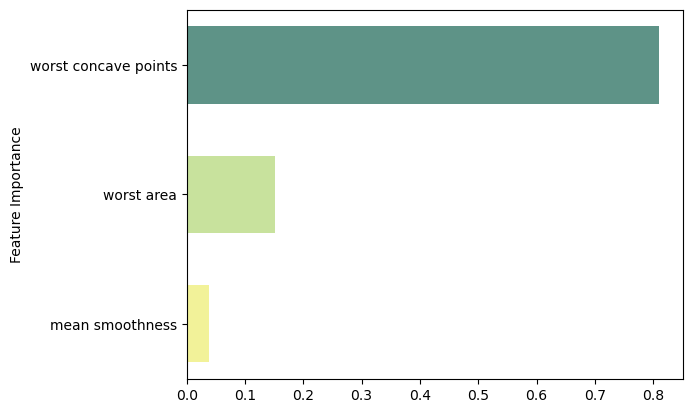

In [8]:
#| label: fig-feat-imp-bagg1
#| fig-cap: Feature Importance Bagging Classifier
#| code-fold: true

feat_importance = bagging.base_estimator_.feature_importances_
column_names = df.drop(columns='target').columns.tolist()

fimp_df = pd.DataFrame(feat_importance, column_names).reset_index().sort_values(0, ascending=False).head(3)

# Setup
fig, ax = plt.subplots()

# Setup
data = fimp_df.loc[:,0].sort_values()
index = np.arange(data.shape[0])
bar_labels = fimp_df.sort_values(0).loc[:,'index'].tolist()
bar_colors = ['#F2F299', '#C8E29D', '#5E9387', '#58828B']
bar_width = 0.6

# Figure
ax.barh(index, data, bar_width, label=bar_labels, color=bar_colors)

# Labels
ax.set_ylabel('Feature Importance')
ax.set_yticks(index, labels=bar_labels)

# Show
plt.show()

### Bagging Regressor

In [9]:
#| label: tbl-raw-dataset
#| tbl-cap: Boston  Dataset
#| code-fold: true
from ISLP import load_data, confusion_table
df = load_data("Boston")

df.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor as Bagging
from sklearn.tree import DecisionTreeRegressor

# Target vs Inputs
X = df.drop(columns=["medv"]) # Covariates-Only
y = df["medv"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create the base classifier
base_classifier = DecisionTreeRegressor() # this is the default if we skip this step
 
# Number of base models (iterations)
n_estimators = 10 # default

# Initialize Bagging Classifier
bagging = Bagging(base_estimator=base_classifier, n_estimators=n_estimators, random_state=0)

# Train Model
bagging.fit(X_train, y_train)

# Predict
y_test_pred = bagging.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , bagging.score(X_train, y_train).round(2) ) 
print('R2 Test' , bagging.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

R2 Train 0.98
R2 Test 0.74
Test MSE: 21.37


#### Adjust `base_estimator`

In [12]:
import sklearn.model_selection as skm
from sklearn.tree import DecisionTreeRegressor

# Initialize Decision Tree Regressor
dtree = DecisionTreeRegressor(random_state=0)

ccp_path = dtree.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)

# Grid Search
grid = skm.GridSearchCV(dtree, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')

# Fit Model
G = grid.fit(X_train, y_train)

print('Optimal Alpha:', grid.best_score_.round(2))

Optimal Alpha: -15.28


In [13]:
# Create the base regressor
base_regressor = grid.best_estimator_
 
# Number of base models (iterations)
n_estimators = 10

# Initialize Bagging Regressor
bagging = Bagging(base_estimator=base_regressor, n_estimators=n_estimators, random_state=0)

# Train Model
bagging.fit(X_train, y_train)

# Predict
y_test_pred = bagging.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , bagging.score(X_train, y_train).round(2) ) 
print('R2 Test' , bagging.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

Accuracy Train 0.95
Accuracy Test 0.73
Test MSE: 21.7


In this case, the pruned tree performance is slightly worse.

#### Feature Importance

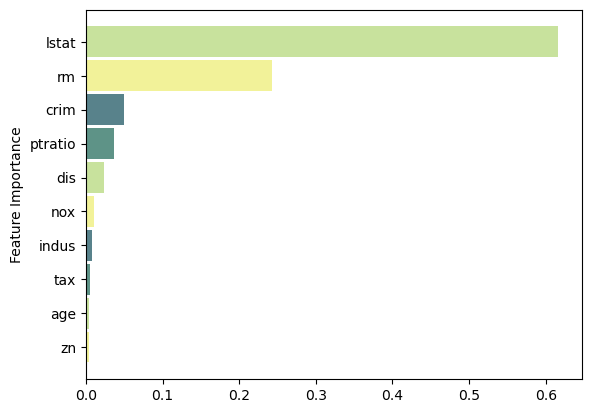

In [15]:
#| label: fig-feat-imp-bagg2
#| fig-cap: Feature Importance Bagging Regressor
#| code-fold: true

feat_importance = bagging.base_estimator_.feature_importances_
column_names = df.drop(columns='medv').columns.tolist()
fimp_df = pd.DataFrame(feat_importance, column_names).reset_index().sort_values(0, ascending=False).head(10)

# Setup
fig, ax = plt.subplots()

# Setup
data = fimp_df.loc[:,0].sort_values()
index = np.arange(data.shape[0])
bar_labels = fimp_df.sort_values(0).loc[:,'index'].tolist()
bar_colors = ['#F2F299', '#C8E29D', '#5E9387', '#58828B']
bar_width = 0.9

# Figure
ax.barh(index, data, bar_width, label=bar_labels, color=bar_colors)

# Labels
ax.set_ylabel('Feature Importance')
ax.set_yticks(index, labels=bar_labels)

# Show
plt.show()

# Random Forest

With bagging we are using in each split the **full set of** $\textbf X$ variables available, so we tend to construct _very **similar** trees_. Therefore, **the trees will be very correlated**, and their average will not result in a variance reduction.
-  If there is a strong predictor in the dataset, most or all trees will be similar to each other since the top split will be the strong predictor. Consequently, all of the bagged trees will look quite similar to each other.

In **Random Forests**, at each split, ***we take a random sample of $m$ covariates*** chosen as split candidates *from the full set of $p$ predictors*.  A fresh sample of $m$ predictors is taken at each split.

- *The split is allowed to use only one of those $m$ predictors.*
- The default is $m \approx \sqrt{p}$ for ***classification*** and $m=p/3$ for ***regression***.

> **Decorrelating Trees**: Random forests overcome this problem by forcing each split to _consider only a subset of the predictors_. 

The main difference between bagging and random forests is the choice of predictor subset size $m$. For instance, if a random forest is built using $m = p$, then this amounts simply to bagging.

## Model Training

The random forest classifier and regressor are implemented in `RandomForestClassifier` and RandomForestRegressor classes from `sklearn.ensemble` module, respectively. Many hyperparameters in these algorithms are similar to `scikit-learn` implementation of CART with the same functionality but applied to all underlying base trees.

### Random Forest Classifier

In [38]:
#| code-fold: true
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Breast Cancer Data
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

# Target vs Inputs
X = df.drop(columns=["target"]) # Covariates-Only
y = df["target"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
from sklearn.ensemble import RandomForestClassifier as RF

# Initialize Random Forest Classifier
rforest = RF(random_state=0)

# Train Model
rforest.fit(X_train, y_train)

# Predict
y_test_pred = rforest.predict(X_test)

In [40]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('Accuracy Train' , rforest.score(X_train, y_train).round(2) ) 
print('Accuracy Test' , rforest.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

Accuracy Train 1.0
Accuracy Test 0.96
Test MSE: 0.04


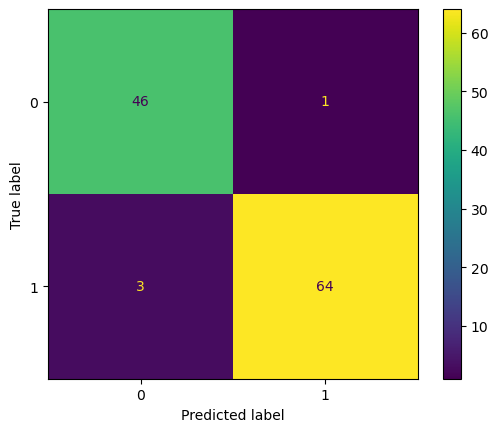

In [41]:
#| label: fig-cmatrix1
#| fig-cap: Confusion Matrix
#| code-fold: true
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rforest, X_test, y_test)
plt.show()

#### Feature Importance

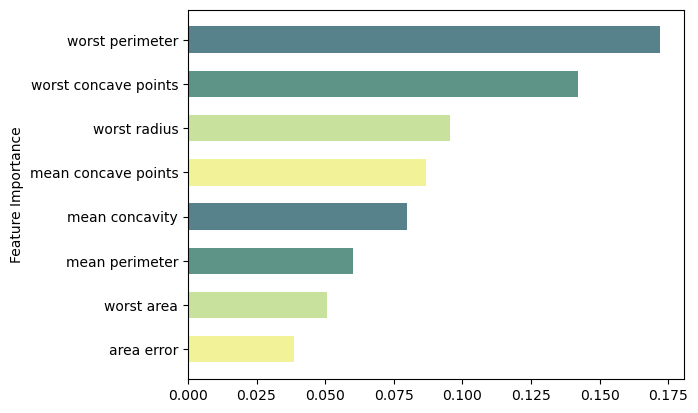

In [37]:
#| label: fig-feat-imp-rf1
#| fig-cap: Feature Importance Random Forest Classifier
#| code-fold: true

feat_importance = rforest.feature_importances_
column_names = df.drop(columns='target').columns.tolist()
fimp_df = pd.DataFrame(feat_importance, column_names).reset_index().sort_values(0, ascending=False).head(8)

# Setup
fig, ax = plt.subplots()

# Setup
data = fimp_df.loc[:,0].sort_values()
index = np.arange(data.shape[0])
bar_labels = fimp_df.sort_values(0).loc[:,'index'].tolist()
bar_colors = ['#F2F299', '#C8E29D', '#5E9387', '#58828B']
bar_width = 0.6

# Figure
ax.barh(index, data, bar_width, label=bar_labels, color=bar_colors)

# Labels
ax.set_ylabel('Feature Importance')
ax.set_yticks(index, labels=bar_labels)

# Show
plt.show()

### Random Forest Regressor

In [24]:
#| code-fold: true
from ISLP import load_data, confusion_table
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Boston Dataset
df = load_data("Boston")

# Target vs Inputs
X = df.drop(columns=["medv"]) # Covariates-Only
y = df["medv"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
from sklearn.ensemble import RandomForestRegressor as RF

# Initialize Random Forest Regressor
rforest = RF(random_state=0)

# Train Model
rforest.fit(X_train, y_train)

# Predict
y_test_pred = rforest.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , rforest.score(X_train, y_train).round(2) ) 
print('R2 Test' , rforest.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

R2 Train 0.98
R2 Test 0.77
Test MSE: 18.71


#### Feature Importance

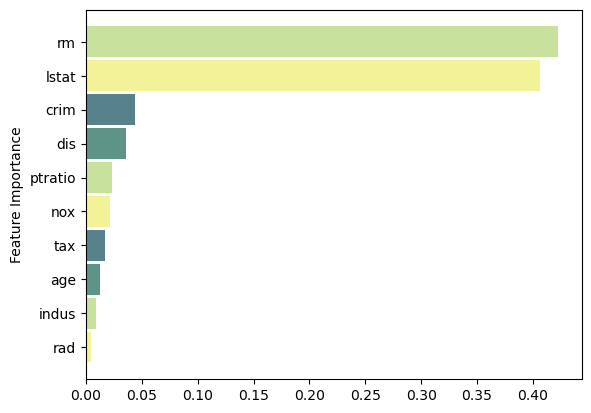

In [29]:
#| label: fig-feat-imp-rf2
#| fig-cap: Feature Importance Random Forest Regressor
#| code-fold: true

feat_importance = rforest.feature_importances_
column_names = df.drop(columns='medv').columns.tolist()
fimp_df = pd.DataFrame(feat_importance, column_names).reset_index().sort_values(0, ascending=False).head(10)

# Setup
fig, ax = plt.subplots()

# Setup
data = fimp_df.loc[:,0].sort_values()
index = np.arange(data.shape[0])
bar_labels = fimp_df.sort_values(0).loc[:,'index'].tolist()
bar_colors = ['#F2F299', '#C8E29D', '#5E9387', '#58828B']
bar_width = 0.9

# Figure
ax.barh(index, data, bar_width, label=bar_labels, color=bar_colors)

# Labels
ax.set_ylabel('Feature Importance')
ax.set_yticks(index, labels=bar_labels)

# Show
plt.show()

# Boosting

In Bagging, each tree is built on a bootstrap data set, independent of the other trees. **Boosting** works in a similar way, except that the ***trees are grown sequentially***: ***each tree is grown using information from previously grown trees***.

> **Boosting** does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly, building smaller trees. 
- Given the current model, we fit a decision tree to the residuals from the model. 
- Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

## Model Training

Here we will only use Regressor as example, but the same procedure applies for the Classifier methods.

In [2]:
#| code-fold: true
from ISLP import load_data, confusion_table
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Boston Dataset
df = load_data("Boston")

# Target vs Inputs
X = df.drop(columns=["medv"]) # Covariates-Only
y = df["medv"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### AdaBoost

`AdaBoost.SAMME` can be implemented using `AdaBoostClassifier` from `sklearn.ensemble` module by setting the algorithm parameter to `SAMME`. AdaBoost.R2 is implemented by `AdaBoostRegressor` from the same module. Using `base_estimator` parameter, both `AdaBoostClassifier` and `AdaBoostRegressor` can take as input a user-specified base model along with its hyperparameters. 
- If this parameter is not specified, by default a decision stump (a `DecisionTreeClassifier` with `max_depth` of 1) will be used. 

In [3]:
from sklearn.ensemble import AdaBoostRegressor as boosting

# Initialize Boosting Regressor
adaboost = boosting(random_state=0)

# Train Model
adaboost.fit(X_train, y_train)

# Predict
y_test_pred = adaboost.predict(X_test)

In [4]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , adaboost.score(X_train, y_train).round(2) ) 
print('R2 Test' , adaboost.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

R2 Train 0.92
R2 Test 0.64
Test MSE: 29.02


#### Adjust `base_estimator`

In [5]:
import sklearn.model_selection as skm
from sklearn.tree import DecisionTreeRegressor

# Initialize Decision Tree Regressor
dtree = DecisionTreeRegressor(random_state=0)

ccp_path = dtree.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)

# Grid Search
grid = skm.GridSearchCV(dtree, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')

# Fit Model
G = grid.fit(X_train, y_train)

print('Optimal Alpha:', grid.best_score_.round(2))

Optimal Alpha: -15.28


In [6]:
# Create the base regressor
base_regressor = grid.best_estimator_
 
# Number of base models (iterations)
n_estimators = 50 # default

# Initialize Bagging Regressor
adaboost = boosting(base_estimator=base_regressor, n_estimators=n_estimators, random_state=0)

# Train Model
adaboost.fit(X_train, y_train)

# Predict
y_test_pred = adaboost.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , adaboost.score(X_train, y_train).round(2) ) 
print('R2 Test' , adaboost.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

R2 Train 0.98
R2 Test 0.67
Test MSE: 26.62


#### Feature Importance

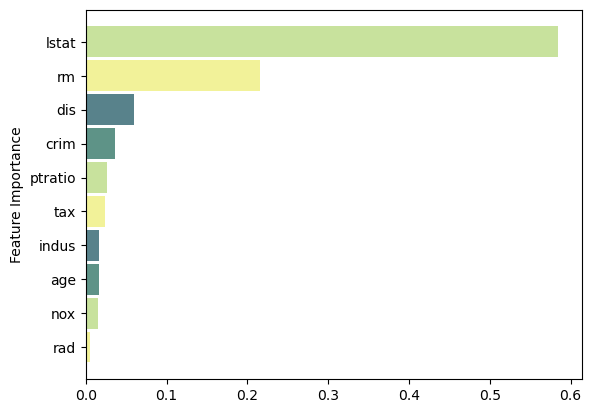

In [11]:
#| label: fig-feat-imp-adaboost
#| fig-cap: Feature Importance AdaBoost Regressor
#| code-fold: true

feat_importance = adaboost.feature_importances_
column_names = df.drop(columns='medv').columns.tolist()
fimp_df = pd.DataFrame(feat_importance, column_names).reset_index().sort_values(0, ascending=False).head(10)

# Setup
fig, ax = plt.subplots()

# Setup
data = fimp_df.loc[:,0].sort_values()
index = np.arange(data.shape[0])
bar_labels = fimp_df.sort_values(0).loc[:,'index'].tolist()
bar_colors = ['#F2F299', '#C8E29D', '#5E9387', '#58828B']
bar_width = 0.9

# Figure
ax.barh(index, data, bar_width, label=bar_labels, color=bar_colors)

# Labels
ax.set_ylabel('Feature Importance')
ax.set_yticks(index, labels=bar_labels)

# Show
plt.show()

### Gradient Boosting

GBRT for classification and regression are  implemented using `GradientBoostingClassifier` and `GradientBoostingRegressor` classes from `sklearn.ensemble` module, respectively. By default a regression tree of `max_depth` of 3 will be used as the base learner. The `n_estimators=100` parameter controls the maximum number of base models (M in the aforementioned algorithms). The supported loss values for `GradientBoostingClassifier` are deviance and exponential, and for `GradientBoostingRegressor` are `squared_error`, `absolute_error`, and two more options. 

In [13]:
from sklearn.ensemble import GradientBoostingRegressor as boosting

# Initialize Boosting Regressor
gradient = boosting(random_state=0)

# Train Model
gradient.fit(X_train, y_train)

# Predict
y_test_pred = gradient.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , gradient.score(X_train, y_train).round(2) ) 
print('R2 Test' , gradient.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

R2 Train 0.98
R2 Test 0.78
Test MSE: 17.98


### XGBoost

XGBoost is not part of scikit-learn but its Python library can be installed and it has a scikit-learn API that makes it accessible similar to many other estimators in scikit-learn. One can use Conda package manager to install **`xgboost`** package for Python. 

As XGBoost is essentially a form of GBRT, it can be used for both classification and regression. 

- The classifier and regressor classes can be imported as from `xgboost import XGBClassifier` and from `xgboost import XGBRegressor`, respectively. 
- Once imported, they can be used similarly to scikit-learn estimators. Some of the important hyperparameters in these classes are `n_estimators`, `max_depth`, `gamma`, `reg_lambda`, and `learning_rate`.

In [15]:
from xgboost import XGBRegressor as boosting

# Initialize Boosting Regressor
xgb = boosting(random_state=0)

# Train Model
xgb.fit(X_train, y_train)

# Predict
y_test_pred = xgb.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , xgb.score(X_train, y_train).round(2) ) 
print('R2 Test' , xgb.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

R2 Train 1.0
R2 Test 0.73
Test MSE: 22.39
